In [1]:
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import os

In [2]:
base_dir="/content/drive/MyDrive/TESS Toronto emotional speech set data"

In [3]:
def extract_features(file_path):
    # Load audio file
    y, sr = librosa.load(file_path)

    # Extract features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft, axis=1)

    fft = np.fft.fft(y)
    fft_mean = np.mean(np.abs(fft))

    mfccs = librosa.feature.mfcc(y=y, sr=sr)
    mfccs_mean = np.mean(mfccs, axis=1)

    spectrogram = librosa.amplitude_to_db(librosa.stft(y))
    spectrogram_mean = np.mean(spectrogram, axis=1)

    # Concatenate features
    features = np.concatenate((chroma_stft_mean, [fft_mean], mfccs_mean, spectrogram_mean))

    return  chroma_stft,fft_mean,mfccs_mean,spectrogram_mean

In [4]:
data =[]

In [6]:
for class_dir in os.listdir(base_dir):
    class_path = os.path.join(base_dir, class_dir)
    if os.path.isdir(class_path):
        # Loop through each audio file in the class directory
        for file_name in os.listdir(class_path):
            if file_name.endswith('.wav'):
                file_path = os.path.join(class_path, file_name)
                chroma_stft,fft_mean,mfccs_mean,spectrogram_mean = extract_features(file_path)
                # Combine the file name, class, and features into one row
                row = [file_name, class_dir, chroma_stft,fft_mean,mfccs_mean,spectrogram_mean]
                data.append(row)

<ipython-input-3-d9b3f246c7a3>:15: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  spectrogram = librosa.amplitude_to_db(librosa.stft(y))


In [7]:
columns = ['file_name', 'class','chroma_stft_mean', 'fft_mean', 'mfccs_mean', 'spectrogram_mean']
df = pd.DataFrame(data, columns=columns)

In [8]:
for col in ['mfccs_mean', 'chroma_stft_mean', 'spectrogram_mean']:
    df[col] = df[col].apply(lambda x: np.array(x).flatten())

In [9]:
max_length = max(len(arr) for arr in df['chroma_stft_mean'])

In [10]:
df_spect= pd.concat([df["class"],   pd.DataFrame(df['spectrogram_mean'].tolist(), columns=[f'spectrogram_mean_{i}' for i in range(len(df['spectrogram_mean'].iloc[0]))])], axis=1)

In [11]:
df_spect.fillna(0, inplace=True)

In [12]:
df['class'] = df['class'].replace({'neutral':0, 'disgust':1,'Sad':2,'Pleasant_surprise':3, 'angry':4, 'Fear':5,
       'happy':6})


In [13]:
y = df['class'].values

In [14]:
X = df_spect.drop(columns=['class']).values

In [16]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [17]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [18]:
X = X.reshape((X.shape[0], 1, X.shape[1]))

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.4003 - loss: 1.6377 - val_accuracy: 0.8304 - val_loss: 0.8343
Epoch 2/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8761 - loss: 0.6640 - val_accuracy: 0.9598 - val_loss: 0.2006
Epoch 3/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9810 - loss: 0.1499 - val_accuracy: 0.9643 - val_loss: 0.1204
Epoch 4/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9768 - loss: 0.1090 - val_accuracy: 0.9732 - val_loss: 0.1099
Epoch 5/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9760 - loss: 0.0983 - val_accuracy: 0.9866 - val_loss: 0.0596
Epoch 6/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9957 - loss: 0.0471 - val_accuracy: 0.9688 - val_loss: 0.0897
Epoch 7/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9945 - loss: 0.0325 - val_accuracy: 0.9777 - val_loss: 0.0601
Epoch 8/50
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9787 - loss: 0.0776 - val_accuracy: 0.9888 - v

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        76
           1       1.00      0.97      0.98        89
           2       0.99      1.00      0.99        77
           3       0.99      0.99      0.99        86
           4       0.99      1.00      0.99        76
           5       1.00      1.00      1.00        83
           6       1.00      1.00      1.00        73

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



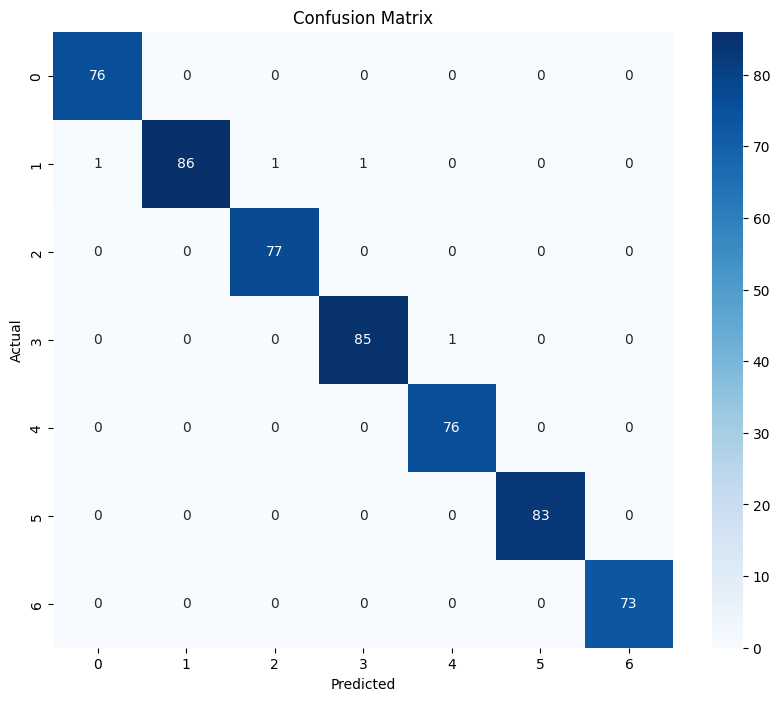

In [25]:
print("Classification Report:")
# Convert label_encoder.classes_ to a list of strings
target_names = [str(cls) for cls in label_encoder.classes_]
print(classification_report(y_test, y_pred_classes, target_names=target_names))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names) # Use target_names here as well
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()